# Implementing vanilla Generative Adversarial Network and Deep Convolutional Generative Adversarial Network

In [4]:
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F


In [1]:
latent_dim = 10       # latent dimension
num_epochs = 50       # number of training epochs
batch_size = 512      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 1e-3  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)

This snippet loads the FashionMNIST dataset with a simple ToTensor() transform (scaling images to [0,1]), wraps the training and test splits in PyTorch DataLoaders with the chosen batch_size (shuffling the data for training and test here), and then reads the image shape (mnist_dims, e.g., 28×28) and the total number of pixels when flattened (mnist_dim, e.g., 784) from the first sample to use later when defining models.

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
#from keras.datasets import FashionMNIST
import keras_core as keras

img_transform = transforms.ToTensor()

train_dataset = FashionMNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()

Using TensorFlow backend


2025-09-02 11:13:27.561214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 11:13:27.627199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756804407.657624  442000 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756804407.666932  442000 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 11:13:27.731920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

The Generator maps a latent vector of size latent_dim through three LeakyReLU layers that expand the width (256 → 512 → 1024) and a final linear layer to mnist_dim; it uses tanh at the output so the generated pixels are in [-1, 1], then reshapes to the image size mnist_dims.
The Discriminator flattens an input image to a vector and passes it through three LeakyReLU layers that shrink the width (1024 → 512 → 256) with dropout for regularization, then a final linear + sigmoid to output the probability that the image is real.


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, mnist_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x.view(-1, *mnist_dims)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(mnist_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

This block instantiates the generator and discriminator, optionally wraps them with torch.compile for ahead-of-time graph optimization, and selects a compute device (GPU if available, otherwise CPU). It then moves both models onto that device so tensors and parameters live in the same place during training. Finally, it counts the number of trainable parameters in each network (summing p.numel() for parameters with requires_grad=True) and prints the totals for a quick sense of model size.

In [6]:
generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the GPU (faster).
Number of parameters for generator: 1463312 and discriminator: 1460225


This loop trains a vanilla GAN with Adam (β₁=0.5) by alternating updates: the discriminator learns to classify real images as 1 and detached generator fakes as 0 using BCE, then the generator is updated with the non-saturating loss to make the discriminator predict 1 on its fakes; losses are averaged per epoch and both models run in training mode on the chosen device.

In [7]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 118/118 [00:02<00:00, 41.20it/s]


	Average loss generator vs. discrim.: 0.788 vs. 0.691


Epoch 2: 100%|██████████| 118/118 [00:02<00:00, 43.90it/s]


	Average loss generator vs. discrim.: 0.774 vs. 0.688


Epoch 3: 100%|██████████| 118/118 [00:02<00:00, 46.43it/s]


	Average loss generator vs. discrim.: 0.783 vs. 0.688


Epoch 4: 100%|██████████| 118/118 [00:02<00:00, 47.33it/s]


	Average loss generator vs. discrim.: 0.819 vs. 0.685


Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 41.83it/s]


	Average loss generator vs. discrim.: 0.788 vs. 0.68


Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 42.56it/s]


	Average loss generator vs. discrim.: 0.823 vs. 0.672


Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 42.14it/s]


	Average loss generator vs. discrim.: 0.827 vs. 0.665


Epoch 8: 100%|██████████| 118/118 [00:03<00:00, 35.83it/s]


	Average loss generator vs. discrim.: 0.845 vs. 0.66


Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 45.23it/s]


	Average loss generator vs. discrim.: 0.844 vs. 0.666


Epoch 10: 100%|██████████| 118/118 [00:02<00:00, 44.45it/s]


	Average loss generator vs. discrim.: 0.852 vs. 0.659


Epoch 11: 100%|██████████| 118/118 [00:02<00:00, 46.53it/s]


	Average loss generator vs. discrim.: 0.857 vs. 0.667


Epoch 12: 100%|██████████| 118/118 [00:02<00:00, 46.91it/s]


	Average loss generator vs. discrim.: 0.829 vs. 0.672


Epoch 13: 100%|██████████| 118/118 [00:02<00:00, 42.29it/s]


	Average loss generator vs. discrim.: 0.825 vs. 0.673


Epoch 14: 100%|██████████| 118/118 [00:02<00:00, 43.47it/s]


	Average loss generator vs. discrim.: 0.845 vs. 0.666


Epoch 15: 100%|██████████| 118/118 [00:02<00:00, 44.96it/s]


	Average loss generator vs. discrim.: 0.851 vs. 0.665


Epoch 16: 100%|██████████| 118/118 [00:02<00:00, 42.17it/s]


	Average loss generator vs. discrim.: 0.871 vs. 0.657


Epoch 17: 100%|██████████| 118/118 [00:02<00:00, 41.43it/s]


	Average loss generator vs. discrim.: 0.858 vs. 0.664


Epoch 18: 100%|██████████| 118/118 [00:02<00:00, 41.55it/s]


	Average loss generator vs. discrim.: 0.866 vs. 0.658


Epoch 19: 100%|██████████| 118/118 [00:02<00:00, 42.44it/s]


	Average loss generator vs. discrim.: 0.869 vs. 0.655


Epoch 20: 100%|██████████| 118/118 [00:03<00:00, 34.53it/s]


	Average loss generator vs. discrim.: 0.862 vs. 0.653


Epoch 21: 100%|██████████| 118/118 [00:02<00:00, 41.34it/s]


	Average loss generator vs. discrim.: 0.863 vs. 0.656


Epoch 22: 100%|██████████| 118/118 [00:02<00:00, 41.26it/s]


	Average loss generator vs. discrim.: 0.864 vs. 0.656


Epoch 23: 100%|██████████| 118/118 [00:02<00:00, 44.70it/s]


	Average loss generator vs. discrim.: 0.863 vs. 0.659


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 48.49it/s]


	Average loss generator vs. discrim.: 0.892 vs. 0.645


Epoch 25: 100%|██████████| 118/118 [00:02<00:00, 44.13it/s]


	Average loss generator vs. discrim.: 0.905 vs. 0.641


Epoch 26: 100%|██████████| 118/118 [00:02<00:00, 43.00it/s]


	Average loss generator vs. discrim.: 0.912 vs. 0.645


Epoch 27: 100%|██████████| 118/118 [00:02<00:00, 40.34it/s]


	Average loss generator vs. discrim.: 0.911 vs. 0.634


Epoch 28: 100%|██████████| 118/118 [00:02<00:00, 42.17it/s]


	Average loss generator vs. discrim.: 0.915 vs. 0.635


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 42.24it/s]


	Average loss generator vs. discrim.: 0.898 vs. 0.641


Epoch 30: 100%|██████████| 118/118 [00:02<00:00, 41.27it/s]


	Average loss generator vs. discrim.: 0.935 vs. 0.627


Epoch 31: 100%|██████████| 118/118 [00:02<00:00, 46.32it/s]


	Average loss generator vs. discrim.: 0.919 vs. 0.627


Epoch 32: 100%|██████████| 118/118 [00:03<00:00, 36.12it/s]


	Average loss generator vs. discrim.: 0.926 vs. 0.62


Epoch 33: 100%|██████████| 118/118 [00:02<00:00, 43.95it/s]


	Average loss generator vs. discrim.: 0.912 vs. 0.62


Epoch 34: 100%|██████████| 118/118 [00:02<00:00, 42.04it/s]


	Average loss generator vs. discrim.: 0.905 vs. 0.624


Epoch 35: 100%|██████████| 118/118 [00:02<00:00, 47.32it/s]


	Average loss generator vs. discrim.: 0.915 vs. 0.621


Epoch 36: 100%|██████████| 118/118 [00:02<00:00, 47.35it/s]


	Average loss generator vs. discrim.: 0.925 vs. 0.616


Epoch 37: 100%|██████████| 118/118 [00:02<00:00, 42.26it/s]


	Average loss generator vs. discrim.: 0.932 vs. 0.615


Epoch 38: 100%|██████████| 118/118 [00:02<00:00, 45.29it/s]


	Average loss generator vs. discrim.: 0.939 vs. 0.613


Epoch 39: 100%|██████████| 118/118 [00:02<00:00, 47.49it/s]


	Average loss generator vs. discrim.: 0.969 vs. 0.608


Epoch 40: 100%|██████████| 118/118 [00:02<00:00, 44.25it/s]


	Average loss generator vs. discrim.: 0.981 vs. 0.601


Epoch 41: 100%|██████████| 118/118 [00:02<00:00, 43.28it/s]


	Average loss generator vs. discrim.: 0.986 vs. 0.596


Epoch 42: 100%|██████████| 118/118 [00:02<00:00, 42.98it/s]


	Average loss generator vs. discrim.: 0.975 vs. 0.603


Epoch 43: 100%|██████████| 118/118 [00:02<00:00, 41.11it/s]


	Average loss generator vs. discrim.: 0.966 vs. 0.608


Epoch 44: 100%|██████████| 118/118 [00:03<00:00, 34.16it/s]


	Average loss generator vs. discrim.: 0.987 vs. 0.6


Epoch 45: 100%|██████████| 118/118 [00:02<00:00, 41.12it/s]


	Average loss generator vs. discrim.: 0.978 vs. 0.598


Epoch 46: 100%|██████████| 118/118 [00:02<00:00, 45.80it/s]


	Average loss generator vs. discrim.: 0.999 vs. 0.595


Epoch 47: 100%|██████████| 118/118 [00:02<00:00, 49.28it/s]


	Average loss generator vs. discrim.: 1.02 vs. 0.587


Epoch 48: 100%|██████████| 118/118 [00:02<00:00, 44.96it/s]


	Average loss generator vs. discrim.: 1.02 vs. 0.584


Epoch 49: 100%|██████████| 118/118 [00:02<00:00, 40.15it/s]


	Average loss generator vs. discrim.: 1.01 vs. 0.592


Epoch 50: 100%|██████████| 118/118 [00:02<00:00, 45.28it/s]

	Average loss generator vs. discrim.: 1.04 vs. 0.575
Done.


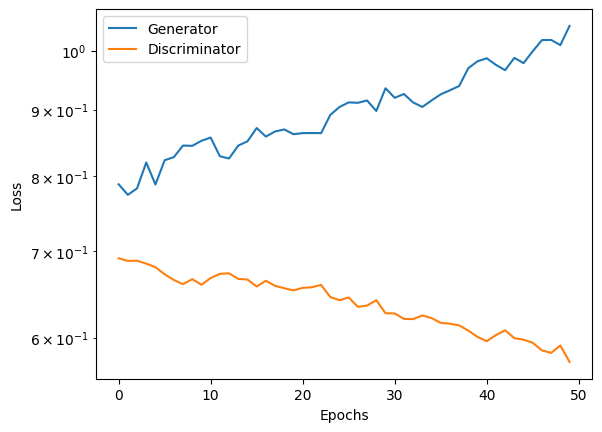

In [8]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Latent space interpolation (GAN)

This cell visualizes how the generator maps straight lines in latent space to images. We sample two latent vectors \(z_1\) and \(z_2\). For \(\lambda \in [0,1]\) we form

$$
z_\lambda = \lambda z_1 + (1-\lambda)\, z_2
$$

and decode each \(z_\lambda\) with the generator (under `torch.no_grad()`), plotting the images from \(\lambda=0\) to \(\lambda=1\).


<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_442000/2150651626.py:40: SyntaxWarning: invalid escape sequence '\l'
  axs[ind].set_title('$\lambda$='+str(round(l,1)))


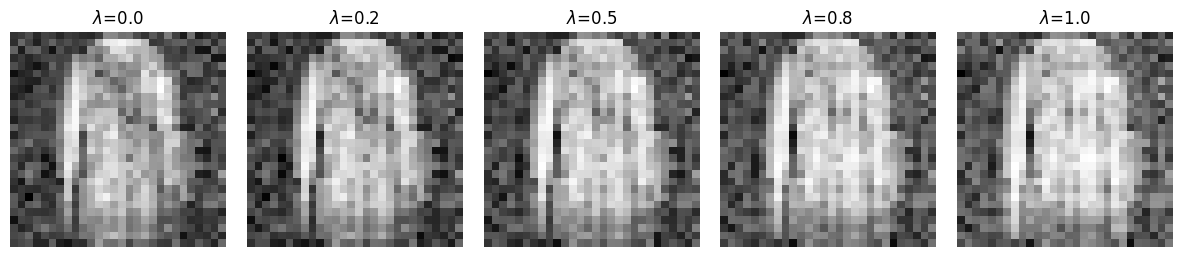

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

This cell switches the generator to evaluation mode, disables gradients, and samples 
𝑛
2
n
2
 latent vectors to produce a batch of fake images. If the generator returns images without a channel dimension, it adds one, then moves the batch to CPU. The helper show_image converts a PyTorch tensor (C×H×W) to a NumPy array (H×W×C), and torchvision.utils.make_grid(..., nrow=n) arranges the batch into an 
𝑛
×
𝑛
n×n image grid. Finally, Matplotlib displays the grid with axes hidden.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9594519..0.9999607].


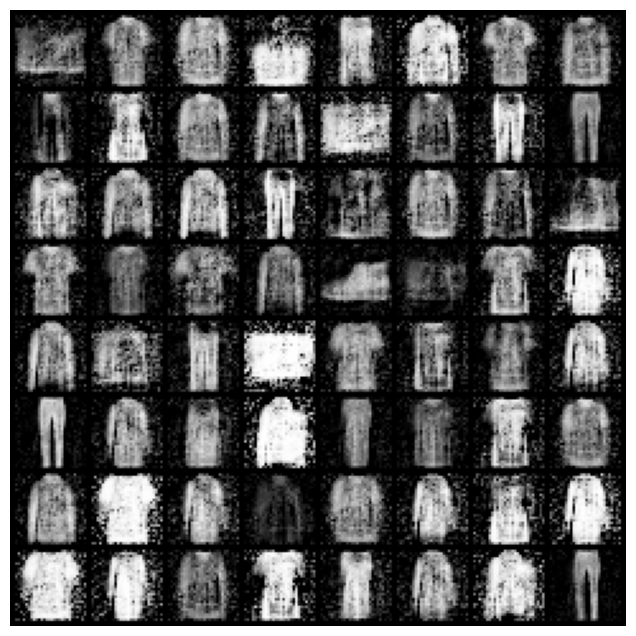

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

This is a DCGAN-style CNN.
The Generator takes a latent vector z of shape (N, latent_dim) and reshapes it to (N, latent_dim, 1, 1), then upsamples with four transposed-conv blocks:

deconv1 (k=5,s=1,p=0) → 5×5, latent_dim×32 channels (BN + ReLU)

deconv2 (k=5,s=1,p=1) → 7×7, latent_dim×16 (BN + ReLU)

deconv3 (k=4,s=2,p=1) → 14×14, latent_dim (BN + ReLU)

deconv4 (k=4,s=2,p=1) → 28×28×1 image, with tanh so outputs lie in [−1, 1] (scale real images to the same range).

The Discriminator does the reverse: it downscales a 28×28×1 image with conv blocks and LeakyReLU (BN in each block), producing spatial sizes 28→14→7→5→1, then flattens and uses a final linear layer to output a single probability via sigmoid (use BCELoss; if you switch to BCEWithLogitsLoss, remove the sigmoid).

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * 32, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * 32)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * 32, latent_dim * 16, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * 16, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, latent_dim // 2, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim // 2)

        self.conv2 = nn.Conv2d(latent_dim // 2, latent_dim, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim)

        self.conv3 = nn.Conv2d(latent_dim, latent_dim * 2, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * 2)

        self.conv4 = nn.Conv2d(latent_dim * 2, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

In [13]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 118/118 [00:02<00:00, 44.81it/s]


	Average loss generator vs. discrim.: 1.04 vs. 0.58


Epoch 2: 100%|██████████| 118/118 [00:02<00:00, 41.99it/s]


	Average loss generator vs. discrim.: 1.02 vs. 0.584


Epoch 3: 100%|██████████| 118/118 [00:02<00:00, 40.95it/s]


	Average loss generator vs. discrim.: 1.03 vs. 0.581


Epoch 4: 100%|██████████| 118/118 [00:02<00:00, 43.17it/s]


	Average loss generator vs. discrim.: 1.03 vs. 0.582


Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 47.77it/s]


	Average loss generator vs. discrim.: 1.03 vs. 0.579


Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 44.51it/s]


	Average loss generator vs. discrim.: 1.03 vs. 0.578


Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 42.71it/s]


	Average loss generator vs. discrim.: 1.07 vs. 0.569


Epoch 8: 100%|██████████| 118/118 [00:03<00:00, 38.92it/s]


	Average loss generator vs. discrim.: 1.05 vs. 0.569


Epoch 9: 100%|██████████| 118/118 [00:03<00:00, 34.56it/s]


	Average loss generator vs. discrim.: 1.07 vs. 0.564


Epoch 10: 100%|██████████| 118/118 [00:02<00:00, 42.04it/s]


	Average loss generator vs. discrim.: 1.09 vs. 0.552


Epoch 11: 100%|██████████| 118/118 [00:02<00:00, 42.46it/s]


	Average loss generator vs. discrim.: 1.07 vs. 0.565


Epoch 12: 100%|██████████| 118/118 [00:02<00:00, 40.99it/s]


	Average loss generator vs. discrim.: 1.08 vs. 0.561


Epoch 13: 100%|██████████| 118/118 [00:02<00:00, 42.84it/s]


	Average loss generator vs. discrim.: 1.05 vs. 0.575


Epoch 14: 100%|██████████| 118/118 [00:02<00:00, 41.82it/s]


	Average loss generator vs. discrim.: 1.09 vs. 0.556


Epoch 15: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s]


	Average loss generator vs. discrim.: 1.09 vs. 0.554


Epoch 16: 100%|██████████| 118/118 [00:02<00:00, 42.11it/s]


	Average loss generator vs. discrim.: 1.08 vs. 0.559


Epoch 17: 100%|██████████| 118/118 [00:02<00:00, 42.87it/s]


	Average loss generator vs. discrim.: 1.1 vs. 0.549


Epoch 18: 100%|██████████| 118/118 [00:02<00:00, 42.75it/s]


	Average loss generator vs. discrim.: 1.09 vs. 0.553


Epoch 19: 100%|██████████| 118/118 [00:02<00:00, 39.60it/s]


	Average loss generator vs. discrim.: 1.1 vs. 0.553


Epoch 20: 100%|██████████| 118/118 [00:02<00:00, 43.13it/s]


	Average loss generator vs. discrim.: 1.12 vs. 0.546


Epoch 21: 100%|██████████| 118/118 [00:02<00:00, 40.99it/s]


	Average loss generator vs. discrim.: 1.11 vs. 0.543


Epoch 22: 100%|██████████| 118/118 [00:02<00:00, 41.15it/s]


	Average loss generator vs. discrim.: 1.11 vs. 0.545


Epoch 23: 100%|██████████| 118/118 [00:02<00:00, 41.90it/s]


	Average loss generator vs. discrim.: 1.12 vs. 0.541


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 41.67it/s]


	Average loss generator vs. discrim.: 1.11 vs. 0.549


Epoch 25: 100%|██████████| 118/118 [00:02<00:00, 42.54it/s]


	Average loss generator vs. discrim.: 1.15 vs. 0.526


Epoch 26: 100%|██████████| 118/118 [00:02<00:00, 42.01it/s]


	Average loss generator vs. discrim.: 1.14 vs. 0.534


Epoch 27: 100%|██████████| 118/118 [00:02<00:00, 40.72it/s]


	Average loss generator vs. discrim.: 1.15 vs. 0.533


Epoch 28: 100%|██████████| 118/118 [00:02<00:00, 41.72it/s]


	Average loss generator vs. discrim.: 1.15 vs. 0.529


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 42.30it/s]


	Average loss generator vs. discrim.: 1.16 vs. 0.525


Epoch 30: 100%|██████████| 118/118 [00:02<00:00, 39.69it/s]


	Average loss generator vs. discrim.: 1.16 vs. 0.533


Epoch 31: 100%|██████████| 118/118 [00:02<00:00, 41.24it/s]


	Average loss generator vs. discrim.: 1.17 vs. 0.533


Epoch 32: 100%|██████████| 118/118 [00:03<00:00, 35.55it/s]


	Average loss generator vs. discrim.: 1.17 vs. 0.523


Epoch 33: 100%|██████████| 118/118 [00:02<00:00, 42.89it/s]


	Average loss generator vs. discrim.: 1.18 vs. 0.52


Epoch 34: 100%|██████████| 118/118 [00:02<00:00, 42.35it/s]


	Average loss generator vs. discrim.: 1.18 vs. 0.518


Epoch 35: 100%|██████████| 118/118 [00:02<00:00, 42.65it/s]


	Average loss generator vs. discrim.: 1.18 vs. 0.518


Epoch 36: 100%|██████████| 118/118 [00:02<00:00, 41.83it/s]


	Average loss generator vs. discrim.: 1.19 vs. 0.517


Epoch 37: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s]


	Average loss generator vs. discrim.: 1.2 vs. 0.512


Epoch 38: 100%|██████████| 118/118 [00:02<00:00, 40.89it/s]


	Average loss generator vs. discrim.: 1.2 vs. 0.516


Epoch 39: 100%|██████████| 118/118 [00:02<00:00, 42.65it/s]


	Average loss generator vs. discrim.: 1.22 vs. 0.509


Epoch 40: 100%|██████████| 118/118 [00:02<00:00, 41.94it/s]


	Average loss generator vs. discrim.: 1.21 vs. 0.517


Epoch 41: 100%|██████████| 118/118 [00:02<00:00, 39.93it/s]


	Average loss generator vs. discrim.: 1.23 vs. 0.505


Epoch 42: 100%|██████████| 118/118 [00:02<00:00, 42.18it/s]


	Average loss generator vs. discrim.: 1.22 vs. 0.506


Epoch 43: 100%|██████████| 118/118 [00:03<00:00, 37.32it/s]


	Average loss generator vs. discrim.: 1.22 vs. 0.511


Epoch 44: 100%|██████████| 118/118 [00:02<00:00, 43.38it/s]


	Average loss generator vs. discrim.: 1.22 vs. 0.508


Epoch 45: 100%|██████████| 118/118 [00:02<00:00, 42.73it/s]


	Average loss generator vs. discrim.: 1.23 vs. 0.507


Epoch 46: 100%|██████████| 118/118 [00:02<00:00, 41.71it/s]


	Average loss generator vs. discrim.: 1.23 vs. 0.512


Epoch 47: 100%|██████████| 118/118 [00:02<00:00, 42.56it/s]


	Average loss generator vs. discrim.: 1.24 vs. 0.506


Epoch 48: 100%|██████████| 118/118 [00:02<00:00, 42.70it/s]


	Average loss generator vs. discrim.: 1.27 vs. 0.493


Epoch 49: 100%|██████████| 118/118 [00:02<00:00, 42.83it/s]


	Average loss generator vs. discrim.: 1.26 vs. 0.499


Epoch 50: 100%|██████████| 118/118 [00:02<00:00, 42.46it/s]

	Average loss generator vs. discrim.: 1.2 vs. 0.532
Done.


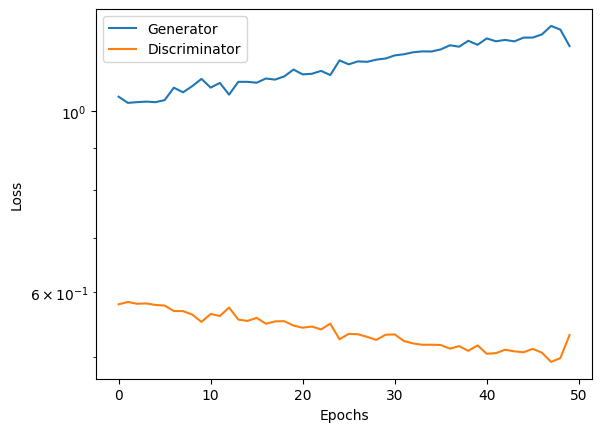

In [14]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_442000/2150651626.py:40: SyntaxWarning: invalid escape sequence '\l'
  axs[ind].set_title('$\lambda$='+str(round(l,1)))


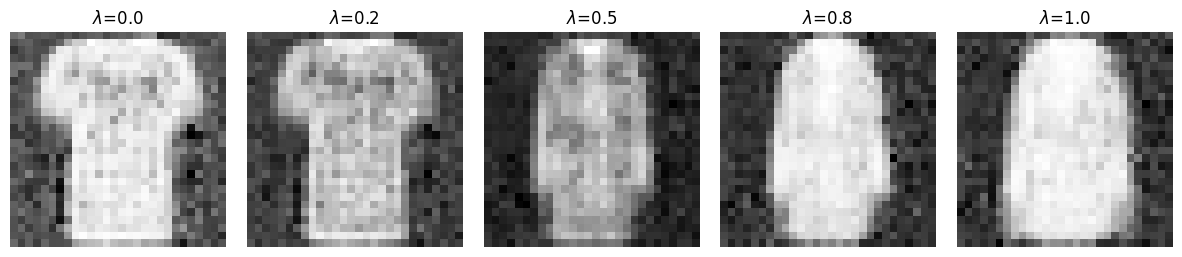

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88848346..0.9999994].


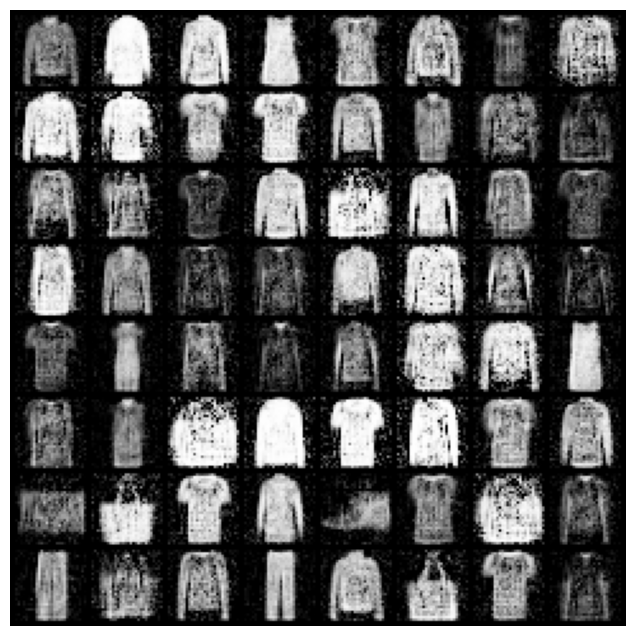

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()